# Exploration 6
## 프로젝트 : 멋진 작사가 만들기

===================================================================================================

## 목차
### (1) 데이터 불러오기
### (2) 데이터 정제
### (3) 모델 학습하여 인공지능 만들기
### (4) 모델 평가하기
### (5) 회고
### (6) Referfence
### (7) 자기다짐 및 아쉬웠던 점

---

## 루브릭 달성 조건

- 1. 데이터의 전처리 및 구성과정이 체계적으로 진행되었는가?
    - 특수문자 제거, 토크나이저 생성, 패딩 처리의 작업들이 빠짐없이 진행되었는가?
- 2. 가사 텍스트 생성 모델이 정상적으로 동작하는가?
    - 텍스트 제너레이션 결과로 생성된 문장이 해석 가능한 문장인가?
- 3. 텍스트 생성모델이 안정적으로 학습되었는가?
    - 텍스트 생성모델의 validation loss가 2.2 이하로 낮아졌는가?
    
---

## (1) 데이터 불러오기

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import glob
import os
import re
import numpy as np
import tensorflow as tf

# txt_file_path = '/content/drive/MyDrive/exploration/06_text_model/data/data/lyrics/*'

txt_file_path = './data/lyrics/*'
txt_list = glob.glob(txt_file_path) # path 경로에 있는 모든 파일명을 리스트 형식으로 txt_list에 할당

raw_corpus = []

# txt 파일을 모두 읽어서 raw_corpus에 담는다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw) # 리스트 함수로 추가적인 내용을 연장한다.

In [4]:
print('데이터 크기: ', len(raw_corpus))
print('Examples: \n', raw_corpus[:10])

데이터 크기:  187088
Examples: 
 ["Now I've heard there was a secret chord", 'That David played, and it pleased the Lord', "But you don't really care for music, do you?", 'It goes like this', 'The fourth, the fifth', 'The minor fall, the major lift', 'The baffled king composing Hallelujah Hallelujah', 'Hallelujah', 'Hallelujah', 'Hallelujah Your faith was strong but you needed proof']


- 데이터를 불러와 raw_corpus라는 리스트에 할당하였습니다.
- 확인해보니 크기는 187088만큼의 크기를 가지고 있군요.
- 데이터도 잘 불러와졌습니다.

---
## (2) 데이터 정제

In [5]:
# 1. 소문자로 바꾸며 양쪽 공백 제거
# 2. 특수문자 양쪽에 공백을 넣음
# 3. 여러개의 공백은 하나의 공백으로 바꿈
# 4. ' 단어를 공백으로 바꿈
# 5. a-zA-Z?.!.¿ 가 아닌 모든 문자를 하나의 공백으로 바꿈
# 6. 다시 양쪽 공백을 지움
# 7. 문장 시작에는 <start>, 끝에는 <end> 를 추가

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿'])", r"\1", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"['.]+", " ", sentence) # 4
    sentence = re.sub(r"[^a-zA-Z?!¿]+", " ", sentence) #5
    sentence = sentence.strip() # 6
    sentence = '<start> ' + sentence + ' <end>' # 7
    return sentence

print(preprocess_sentence("What @_are _'you. .doing?"))

<start> what are you doing? <end>


- 특수문자 등 문장들의 통일성을 위해 소문자, 공백 등을 통하여 변환을 해주었고 시작과 끝에 
- start, end 토큰을 붙여 시작과 끝을 모델이 잘 인지할 수 있도록 해주었습니다.

In [6]:
# 정제된 문장을 모을 리스트 생성
corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0: continue
    if sentence[-1] == ':': continue
        
    ps = preprocess_sentence(sentence)
    corpus.append(ps)
    
corpus[:10]

['<start> now i ve heard there was a secret chord <end>',
 '<start> that david played and it pleased the lord <end>',
 '<start> but you don t really care for music do you? <end>',
 '<start> it goes like this <end>',
 '<start> the fourth the fifth <end>',
 '<start> the minor fall the major lift <end>',
 '<start> the baffled king composing hallelujah hallelujah <end>',
 '<start> hallelujah <end>',
 '<start> hallelujah <end>',
 '<start> hallelujah your faith was strong but you needed proof <end>']

- 위에서 정제한 데이터를 10번째 행까지만 출력해 보았습니다.
  
- ps 함수에 잘 담긴것을 확인할 수 있습니다.

In [7]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=12000,
                                                      filters = " ",
                                                      oov_token='<nope>')
    
    # fit_on_texts(texts)는 문자 데이터를 입력받아 리스트의 형태로 변환하는 메서드입니다.
    tokenizer.fit_on_texts(corpus)
    
    # texts_to_sequences(texts)는 텍스트 안의 단어들을 숫자의 시퀀스 형태로 변환하는 메서드입니다.
    tensor = tokenizer.texts_to_sequences(corpus)
    
    # 토큰의 길이가 15가 넘는 단어들은 제외
    tensor_15 = []

    for i in range(len(tensor)-1):
        if len(tensor[i]) > 15:
            continue
        elif i >= len(tensor)-1:
            break
        elif len(tensor[i]) <= 15:
            tensor_15.append(tensor[i])
    
    # preprocessing.sequence.pad_sequences 함수를 이용하여 모든 문장의 길이를 최댓값으로 맞춰줍니다.
    # padding = 'pre' 를 이용하여 문장의 앞에 <pad> 를 붙여 문장의 길이를 채워줍니다.
    tensor_15 = tf.keras.preprocessing.sequence.pad_sequences(tensor_15, padding='pre')
    
    print(tensor_15, tokenizer)
    return tensor_15, tokenizer

- tokenize 함수를 만들었습니다.
  
  
- 각각 메서드들에 주석을 달아 설명하였고 for문을 통하여 토큰의 길이가 15가 넘는 문장들은 제외하였습니다.
  
  
- 또한 글자의 길이를 15개로 통일하기 위해 패딩을 하였고 패딩은 'pre'를 이용하여 앞에 붙였습니다. 
    - 이는 후에 사용할 LSTM, RNN의 특성때문인데 데이터가 뒤로갈수록 점점 맨 앞의 데이터의 손실을 가져올 수 있기에 앞을 의미없는 정보인 패딩으로 채워주고 데이터를 뒤에 모을 수 있도록 하였습니다.
    
- Tokenizer() 의 파라미터

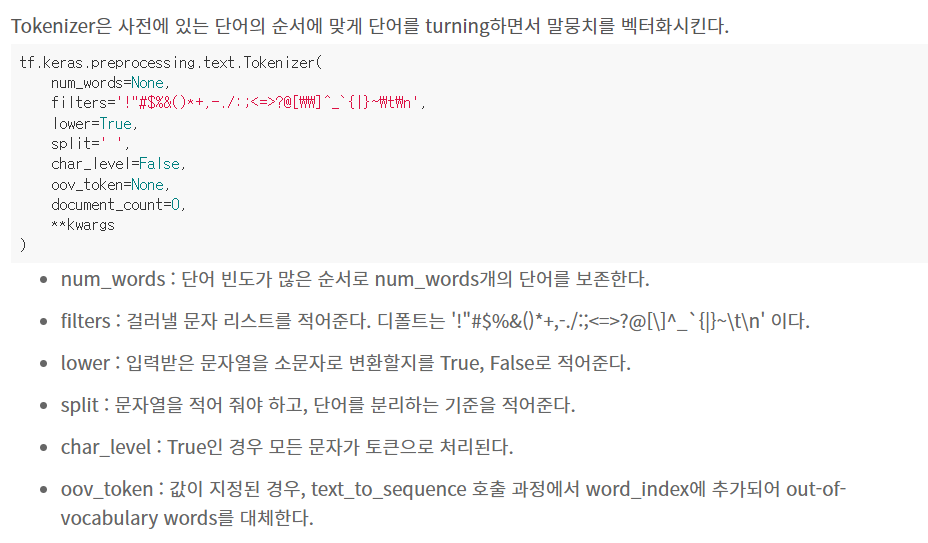

---

In [8]:
tensor, tokenizer = tokenize(corpus)

[[   2   49    4 ...    0    0    0]
 [   2   16 2672 ...    0    0    0]
 [   2   33    6 ...    0    0    0]
 ...
 [   2  693 1118 ...    0    0    0]
 [   2    4  103 ...    0    0    0]
 [   2  250  194 ...    3    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7fd7d4f876d0>


- tensor와 tokenizer 변수에 잘 할당되었군요.

In [9]:
len(tensor)

160370

- 187088 이었던 길이가 160370으로 줄어들었군요
- 전처리가 완료된 것 같습니다.
  
  
- 각각 인덱스의 의미를 10개까지만 살펴보겠습니다.

In [10]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])
    
    if idx == 10: break

1 : <nope>
2 : <start>
3 : <end>
4 : i
5 : the
6 : you
7 : and
8 : to
9 : a
10 : it


- 토큰화가 잘 된것같습니다.

---
### (3) 모델 학습하여 인공지능 만들기

In [11]:
train = tensor[:, :-1]

target = tensor[:, 1:]

- train 데이터와 target 데이터로 나누어 주었습니다.

In [12]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(src_input,
                                                  tgt_input,
                                                  test_size=0.2,
                                                  random_state = 42)

- train 80%, val 20% 비율로 분리해주었습니다.

In [13]:
vocab_size = tokenizer.num_words + 1
buffer_size = len(train)
batch_size = 777
embedding_size = 1212
hidden_size = 2022
epoch = 10

  
    
- 아래에서 사용할 변수들의 크기를 지정해주었습니다.

In [14]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, activation='tanh', return_sequences = True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, activation='tanh', return_sequences = True, dropout=0.1)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
model = TextGenerator(vocab_size, embedding_size, hidden_size)

- 모델 클래스를 지정해 주었습니다.
   - 먼저 모델에 embedding 층을 쌓아 주고 그 위로 LSTM 층을 2겹으로 쌓은 후 Dense층을 출력으로 사용하였습니다.
   
   
   - 모델의 구조
   
   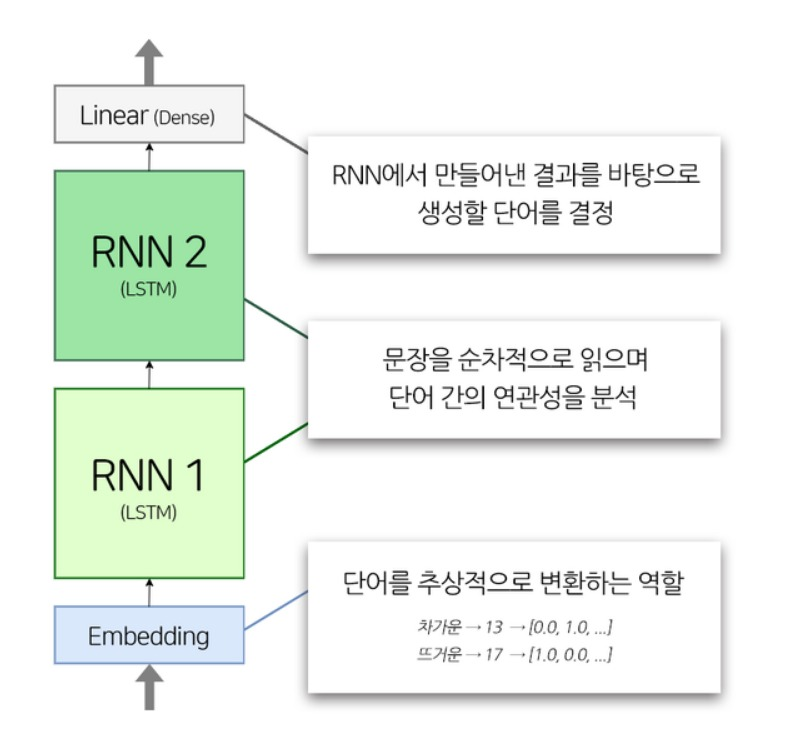
   
   ---

- LSTM()의 파라미터
     
     
   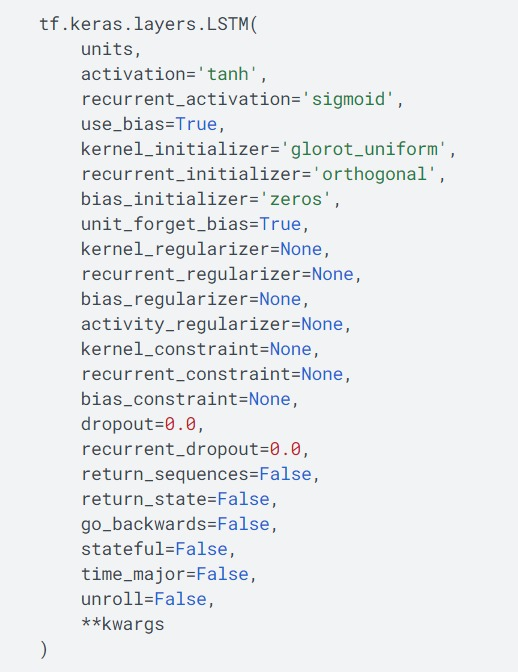

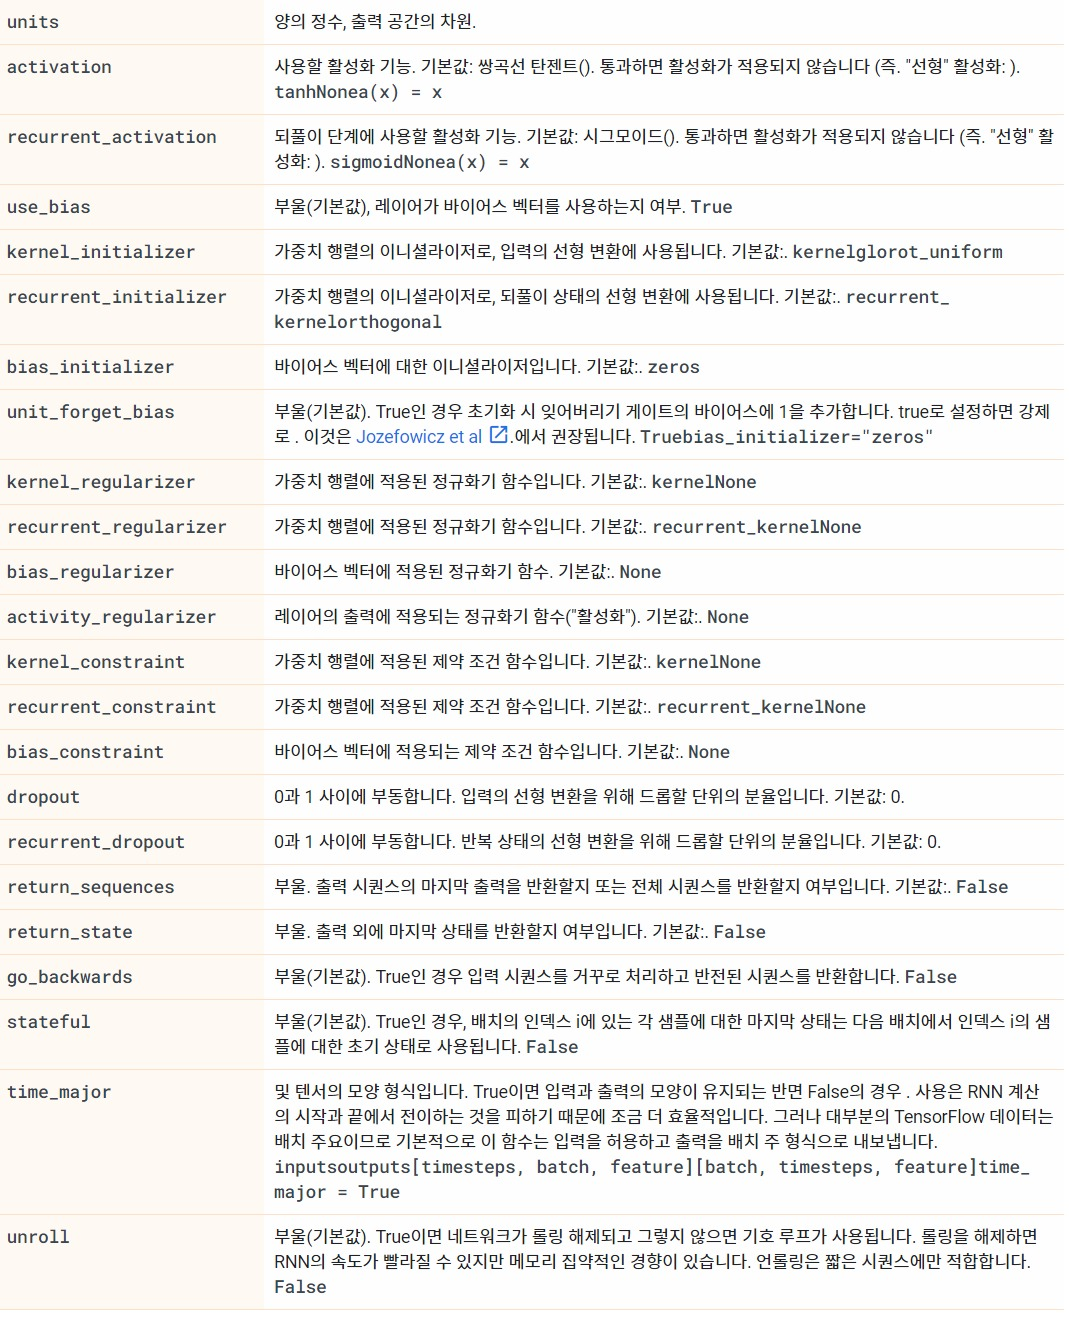

---
- Bidirectional() 함수도 사용하여 양방향 LSTM으로 사용하려했으나.. 오버피팅 문제를 해결하지 못하였고 학습에 문제가 생겨 사용하지 않게 되었습니다.
  
  
- 그래도 유용한 정보이니 기재합니다.
   
   
- Bidirectional() 파라미터
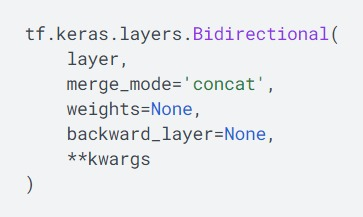

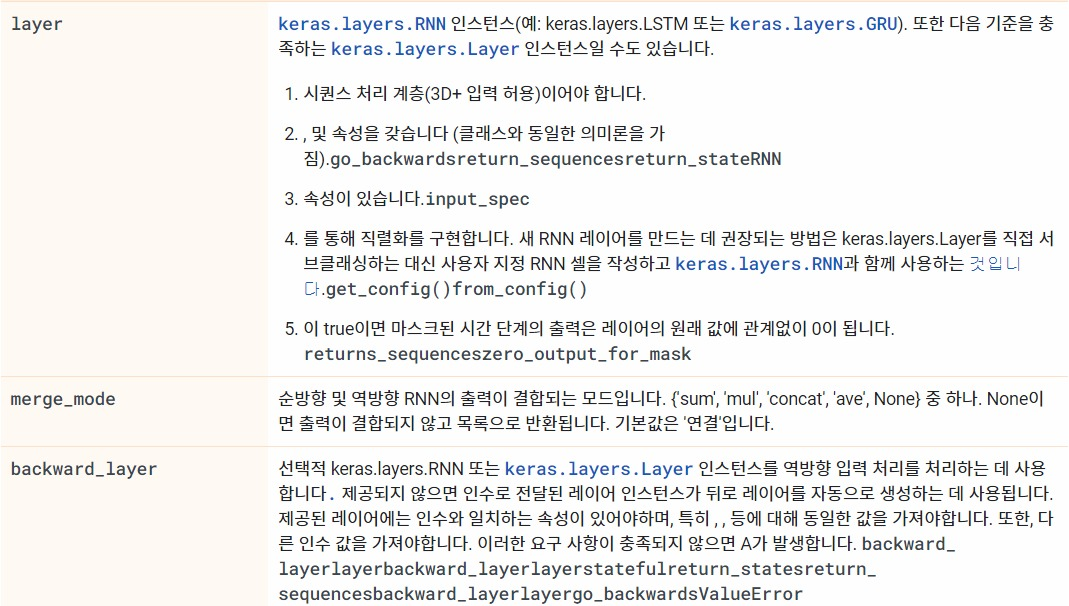

---

In [15]:
dataset = tf.data.Dataset.from_tensor_slices((train, target))
dataset = dataset.shuffle(buffer_size)
dataset = dataset.batch(batch_size, drop_remainder = True)
dataset

<BatchDataset element_spec=(TensorSpec(shape=(512, 14), dtype=tf.int32, name=None), TensorSpec(shape=(512, 14), dtype=tf.int32, name=None))>

- 배치용으로 사용할 dataset을 만들어주었습니다.
- 모델에 배치를 입력하겠습니다.

In [16]:
for src_sample, tgt_sample in dataset.take(1): break
    
model(src_sample)

<tf.Tensor: shape=(512, 14, 20001), dtype=float32, numpy=
array([[[ 7.56678404e-04,  9.68293825e-05, -6.30285766e-04, ...,
         -3.31889954e-04, -8.01418646e-05,  4.65290941e-05],
        [ 9.35523596e-04,  1.44687059e-04, -1.28811179e-03, ...,
         -4.49067331e-04,  1.28160405e-04, -1.35372160e-04],
        [ 9.23471409e-04,  2.15054984e-04, -1.71461864e-03, ...,
         -4.27229010e-04,  1.46149570e-04, -4.30266082e-04],
        ...,
        [ 1.44907332e-03, -2.52291886e-03, -2.69844360e-03, ...,
         -1.44222181e-03,  1.85320372e-04, -2.91746599e-03],
        [ 1.80423190e-03, -2.76729581e-03, -3.19706881e-03, ...,
         -1.93948729e-03,  8.62729386e-04, -2.49327207e-03],
        [ 2.15799059e-03, -2.94648437e-03, -3.76229128e-03, ...,
         -2.48843571e-03,  1.55305874e-03, -1.95265841e-03]],

       [[ 7.56678404e-04,  9.68293825e-05, -6.30285766e-04, ...,
         -3.31889954e-04, -8.01418646e-05,  4.65290941e-05],
        [ 9.64089995e-04,  6.89351989e-04, -1

- 입력이 잘 되었군요

In [18]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                     reduction='none')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=loss)

- loss와 optimizer를 지정하여 모델에 compile 해주었습니다.
  
  
- Optimizer 의 종류

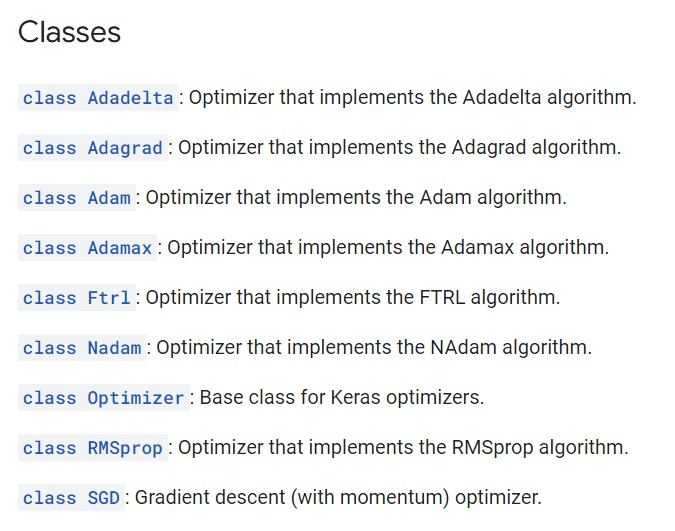

---

- Optimizer Adam 의 파라미터

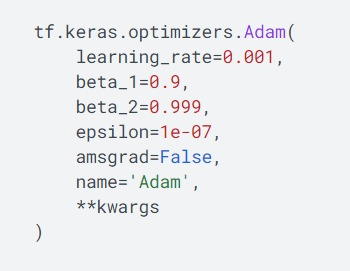

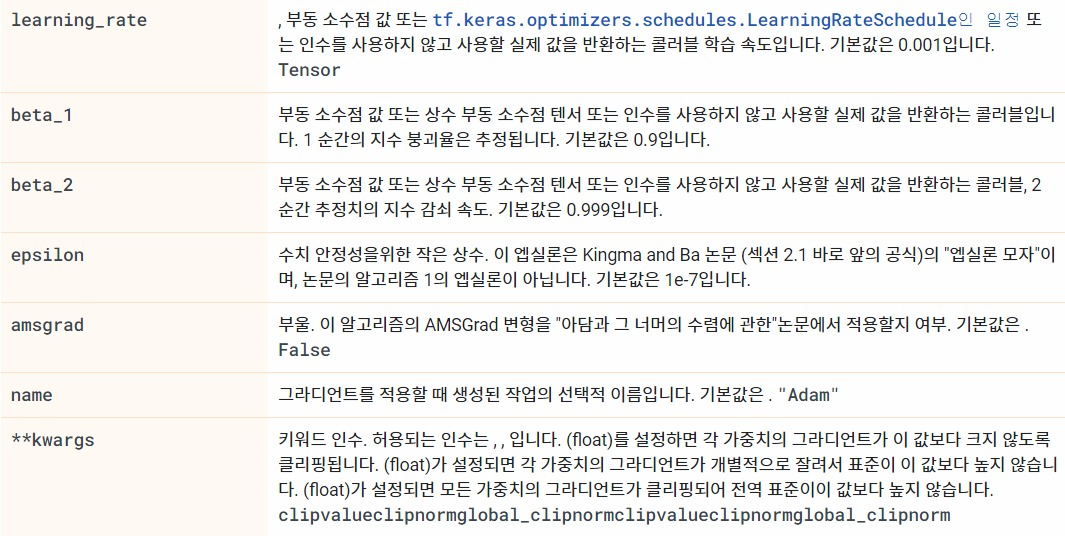

---

In [19]:
model.summary()

Model: "text_generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  20481024  
                                                                 
 lstm (LSTM)                 multiple                  25174016  
                                                                 
 lstm_1 (LSTM)               multiple                  33562624  
                                                                 
 dense (Dense)               multiple                  40982049  
                                                                 
Total params: 120,199,713
Trainable params: 120,199,713
Non-trainable params: 0
_________________________________________________________________


- 약 1억 2천만개의 파라미터를 갖고 있는 딥러닝 모델이 완성되었습니다. 한번 학습시켜보겠습니다.

In [20]:
history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epoch, shuffle=True, validation_data=(x_val, y_val))

Epoch 1/10
251/251 [==============================] - 159s 619ms/step - loss: 3.5607 - val_loss: 3.0863
Epoch 2/10
251/251 [==============================] - 155s 618ms/step - loss: 2.9321 - val_loss: 2.8477
Epoch 3/10
251/251 [==============================] - 155s 618ms/step - loss: 2.6860 - val_loss: 2.6932
Epoch 4/10
251/251 [==============================] - 155s 618ms/step - loss: 2.4573 - val_loss: 2.5676
Epoch 5/10
251/251 [==============================] - 155s 618ms/step - loss: 2.2376 - val_loss: 2.4658
Epoch 6/10
251/251 [==============================] - 155s 618ms/step - loss: 2.0323 - val_loss: 2.3848
Epoch 7/10
251/251 [==============================] - 155s 618ms/step - loss: 1.8399 - val_loss: 2.3180
Epoch 8/10
251/251 [==============================] - 155s 619ms/step - loss: 1.6609 - val_loss: 2.2671
Epoch 9/10
251/251 [==============================] - 155s 618ms/step - loss: 1.4970 - val_loss: 2.2253
Epoch 10/10
251/251 [==============================] - 155s 618m

- val_loss가 2.1986으로 학습이 잘 된것을 확인할 수 있습니다.

- 아래는 model.fit의 파라미터입니다.

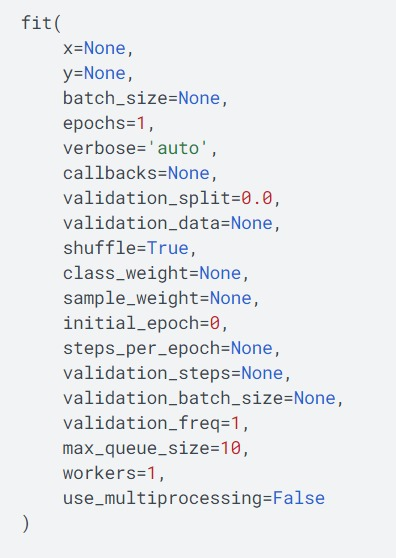

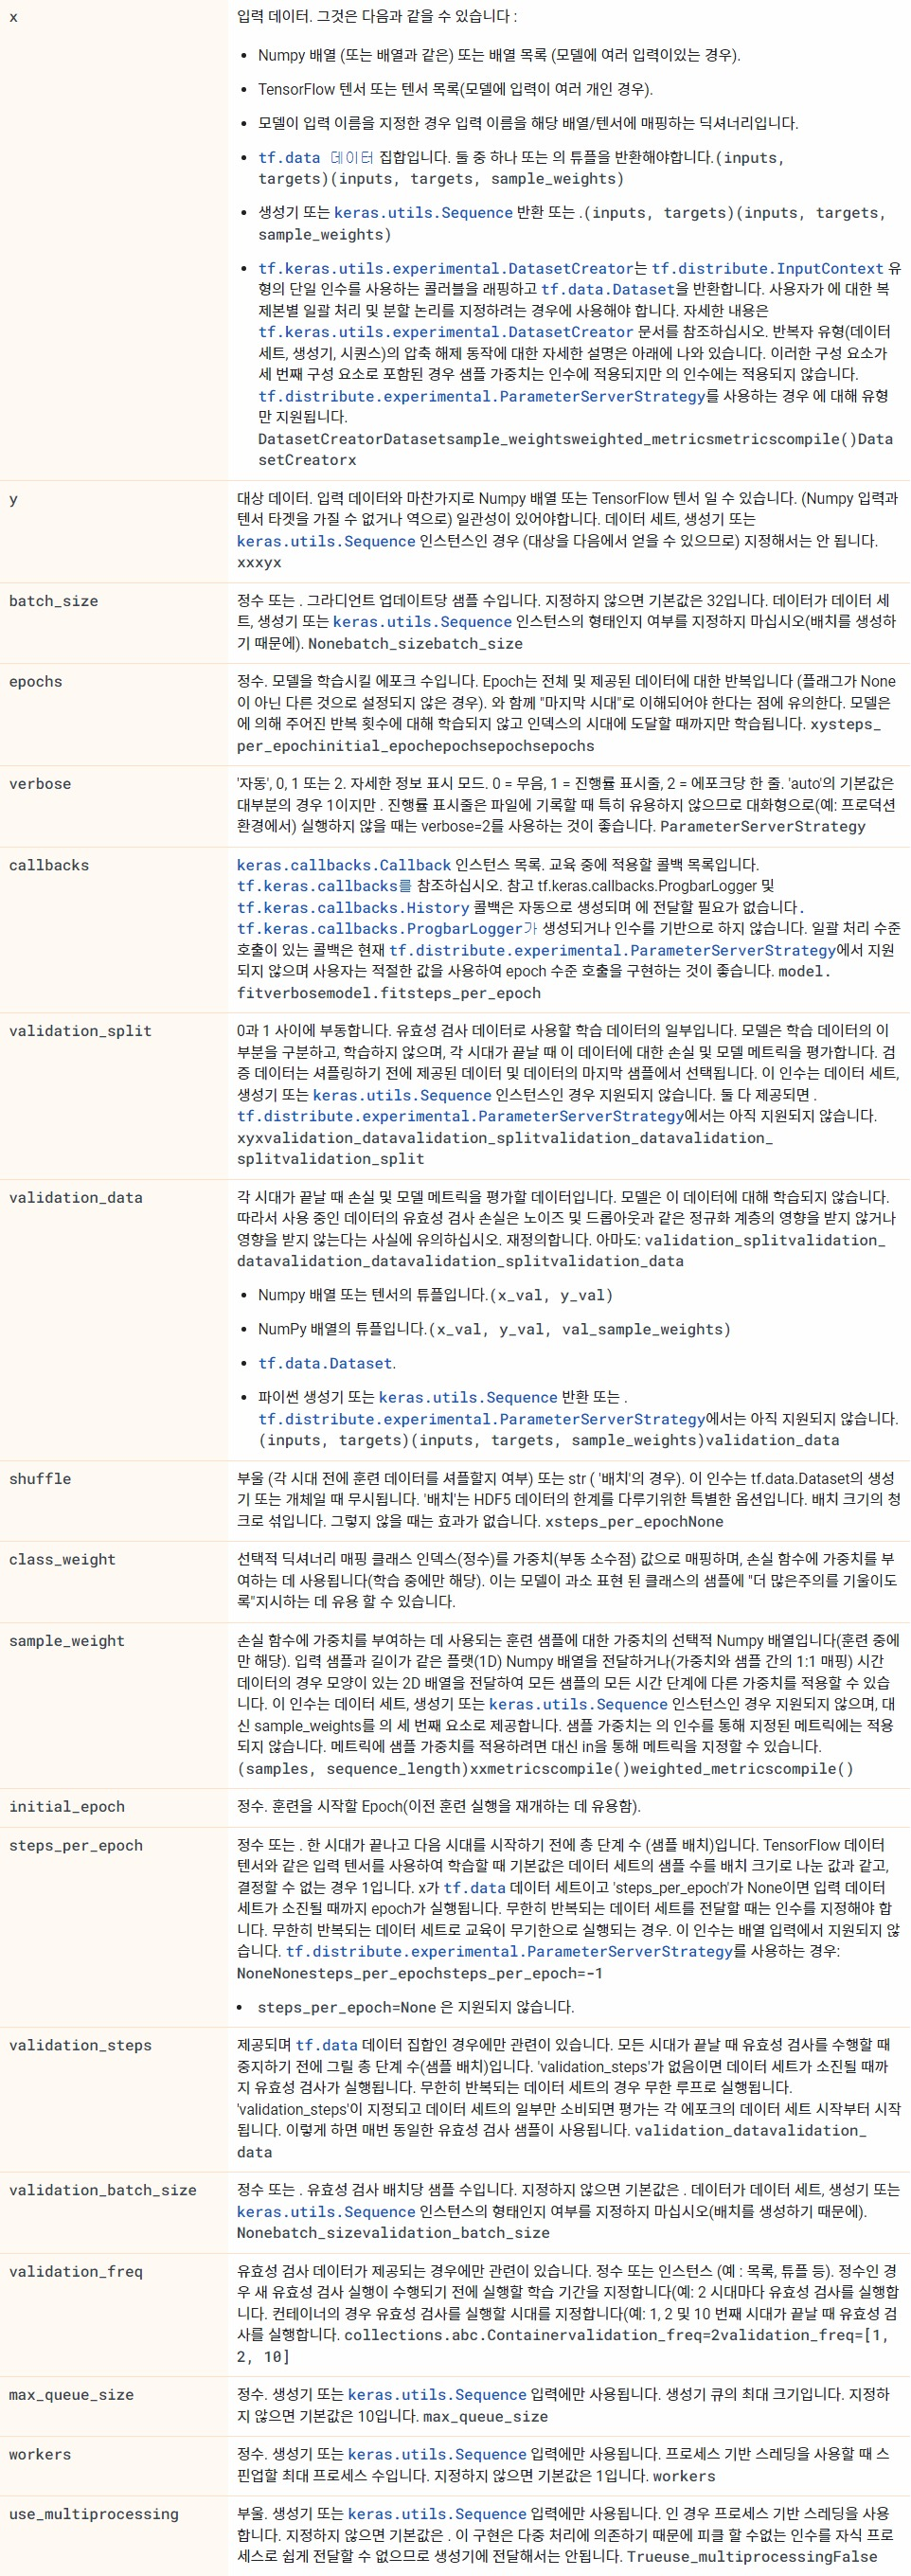

---
### 오류
- Function call stack: train_function -> train_function -> train_function 이라는 오류가 뜸
- 이유로는 batch_size가 커서라는듯 합니다.
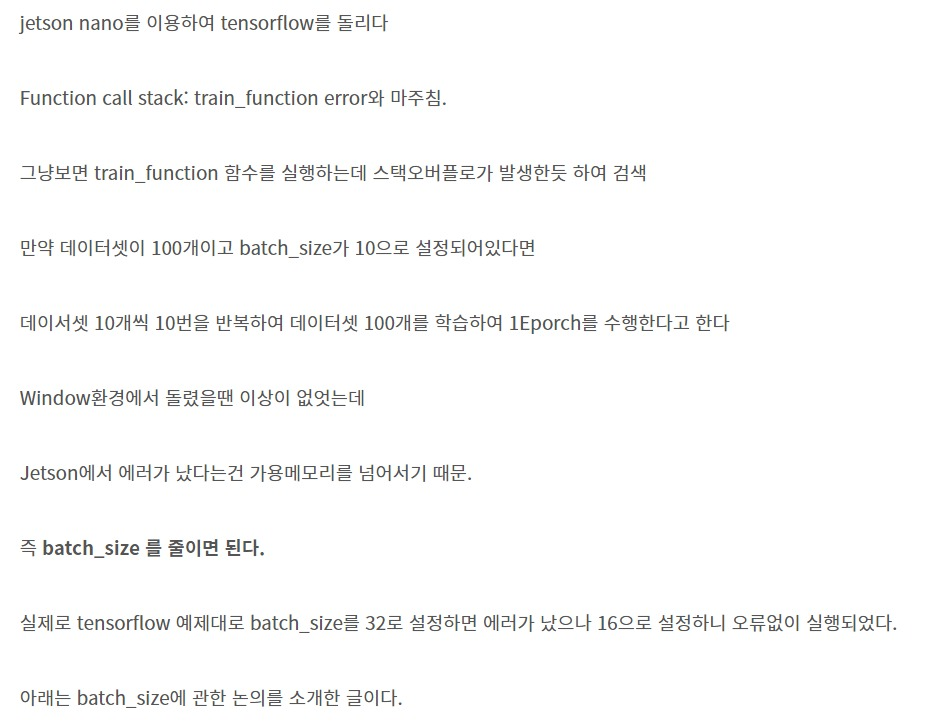


---
### (4) 모델 평가하기

In [27]:
# generate_text 함수는 모델에게 시작 문장을 전달하면 모델이 시작 문장을 바탕으로 작문을 한다.

# 문장 생성 함수 정의
def generate_text(model, tokenizer, init_sentence="<start>", max_len=17):
    # 테스트를 위해 입력받은 init_sentence를 텐서로 변환
    test_input = tokenizer.texts_to_sequences([init_sentence]) # 텍스트 안의 단어를 숫자로 변환
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]
    
    # 단어 하나씩 예측해 문장을 만든다.
    # 1. 입력받은 문장의 텐서를 입력
    # 2. 예측된 값 중 가장 높은 확률인 word index를 뽑아낸다.
    # 3. 2에서 예측된 word index를 문장 뒤에 붙ㅇ니다.
    # 4. 모델이 <end> 를 예측했거나, max_len에 도달했다면 문장 생성을 마침.
    # (max_len에 도달하지 못헀다면 while 루프를 돌면서 다음 단어 예측 )
    # 루프를 돌면서 init_sentence에 단어를 하나씩 생성
    
    while True:
        # 1
        predict = model(test_tensor)
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]
        # 3
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break
            
    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "
        
    return generated # 최종적으로 모델이 생성한 문장을 반환

- 모델이 만들어낸 문장을 반환해주는 함수인 generate_text 함수를 만들었습니다.
- 모델에게 단어를 주고 잘 작성하는지 확인해 보겠습니다.

In [36]:
generate_text(model, tokenizer, init_sentence="<start> my", max_len=30)

'<start> my name is prince <end> '

- 번역: '나의 이름은 왕자이다.'

In [38]:
generate_text(model, tokenizer, init_sentence="<start> you have", max_len=30)

'<start> you have to trust it <end> '

- 번역: '넌 그것을 믿어야해'

In [40]:
generate_text(model, tokenizer, init_sentence="<start> people", max_len=30)

'<start> people say that i m the one to blame <end> '

- 번역 : '사람들은 내게 책임이 있다고 말합니다.'

In [39]:
generate_text(model, tokenizer, init_sentence="<start> please", max_len=30)

'<start> please don t stop the music music music <end> '

- 번역 : '음악 음악 음악을 멈추지 마세요'
  
  
- 아무래도 music이 3번이나 반복되는 특성을 갖는것은 한정된 데이터셋의 문제가 아닐까 싶습니다.
- 노래 가사로 학습을 하였기 때문에 노래가사의 특성을 띄는것 같습니다.

### (5) 회고

- 이번 프로젝트를 하면서 어려웠던 점은 일단 NLP에 대한 개념이 잡히지 않았고 원리가 이해되지 않았으며 특히 함수들에 대해서 이해가 안되는 부분이 많아 구글링과 공식문서의 도움을 많이 받았습니다.
  
  
- 학습한 내용은 RNN, LSTM, Bidirectional 함수, 각각의 파라미터들, 딥러닝 layer 쌓는법 등등 여러가지를 알 게 되었습니다. 도움 된 내용은 Reference에 기재해 놓았습니다.
  
  
- 알아낸 점이나 모호한 점으로는 특히나 이번 프로젝트에 있어 각 함수들의 의미와 파라미터들에 관하여 많이 알아보았고 그렇지만 각각의 파라미터들의 의미에 대해서는 아직 많이 모호합니다. 특히 Bidirectional 함수의 merge_mode로는 'sum','mul','ave','concat',None 이 있지만 defalut 값인 concat 밖에 사용법을 모르겠고 None을 이용하게되면 모델의 길이가 길어지는등 여러가지 문제가 많이 발생하였습니다. LSTM 또한 go_backwards 등 여러가지 파라미터들을 사용해보려했으나 오버피팅의 문제가 발생하는 바람에 제대로 사용해보진못했습니다. 앞으로 좀 더 알아볼것이 많다고 생각합니다.
  
  
- 루브릭 평가지표를 맞추기 위해 노력했던 점으로는
   - __1. 특수문자 제거, 토크나이저 생성, 패딩 처리의 작업들이 빠짐없이 진행되었는가?__ 를 위하여 LMS에서 제공된 preprocess_sentence 함수를 수정하며 결과에 영향을 주는 이상한 단어들을 모두 삭제해 주었습니다. 또한 토크나이저 생성에서도 예시에서 알려주셨듯 문장길이를 15로 제한하였고 패딩또한 점점 뒤로 갈 수록 희미해지는 문장 특성을 띄는 RNN과 LSTM의 특성에 맞게 'pre'를 이용하여 뒷 정보에 더 신경쓸 수 있도록 설정하였습니다.
   - __2. 텍스트 제너레이션 결과로 생성된 문장이 해석 가능한 문장인가?__ 에 대해서는 결과에 기재해 놓았듯 생각보다 더 해석 가능한 문장을 만들었습니다. 처음으로 시도했을때는 my name is prince, 혹은 여러가지 해석은 되나 무언가 애매한 문장들이 많았습니다만 padding을 pre로 설정하니 훨씬 해석하기 좋은 문장이 완성되었습니다.
   - __3. 텍스트 생성모델의 validation loss가 2.2 이하로 낮아졌는가?__ 에 대해서는 제가 맞게 한지는 모르겠습니다만 제 생각으론 tf.keras.layers.Bidirectional() 을 이용하는 것이 더 RNN 학습에는 좋지 않을까? 하는 생각에 적용하여 보았습니다만 그로인해 val_loss가 과하게 떨어지는 모습을 보여주었습니다. 일단 결과적으로 말씀드리자면 2.2보다 월등히 낮게 떨어졌습니다만 부족한 지식으로 인하여 올바르게 모델을 완성한건지는 정확하게 판단을 못하겠습니다.
     
     
- 루브릭 평가지표를 달성하지 못했다면 이유는 아마 문장 해석의 문제이지 않을까 싶습니다. 학습 데이터셋의 범위가 너무 한정적이었고 또한 노래 가사라는 카테고리 안에서 학습을 했기에 일반적인 어휘와는 다른 문장을 구사한듯 싶습니다. 때문에 문제가 발생하지 않았을까 예측해봅니다.

### (6) Reference

- https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN tf.SimpleRNN 공식문서
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional tf.Bidirectional 공식문서
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM tf.LSTM 공식문서
- https://engineer-mole.tistory.com/26 bidirectional 함수 관련 블로그
- https://dgkim5360.tistory.com/entry/understanding-long-short-term-memory-lstm-kr LSTM 이해하기 블로그
- https://ratsgo.github.io/natural%20language%20processing/2017/03/09/rnnlstm/ RNN, LSTM 이해하기 블로그
- https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=chunjein&logNo=221589656211 LSTM, many-to-one, many-to-many 이해하기 블로그
- https://cvml.tistory.com/27 RNN, LSTM 에서 tanh 를 사용하는 이유

### (7) 자기다짐 및 아쉬웠던 점

- 이번 과제에서 딥러닝 레이어 층 쌓는법에 대하여 꽤 심도있게 알게되었고 특히 activation function 들에 관하여 더 알게 되었습니다. 밑시딥에서 배웠던 것과는 다르게 훨씬 사용하기 쉬웠으며 이해도 간편했습니다. 이번 프로젝트가 딥러닝에 관하여서 흥미를 주는 프로젝트였다고 생각합니다.
  
- 좀 아쉬웠던 점은 너무 루브릭에 집중하다보니 다른 파일에 있는 함수나 시각화를 하지 못한점이 아쉽습니다. 또한 한정된 데이터셋이라는 느낌을 받고나서부터는 새로운 데이터셋을 모아보려 노력했지만 아직 구글링의 문제인지 파일을 구하지 못했습니다.
  
  
- 아쉬운 부분이 많았던 노드였고 앞으로도 더욱 노력해야겠다는 생각이 드는 exploration 이었습니다.
  
  
- 때문에 아쉬웠던 부분은 아래 사진으로 첨부합니다.

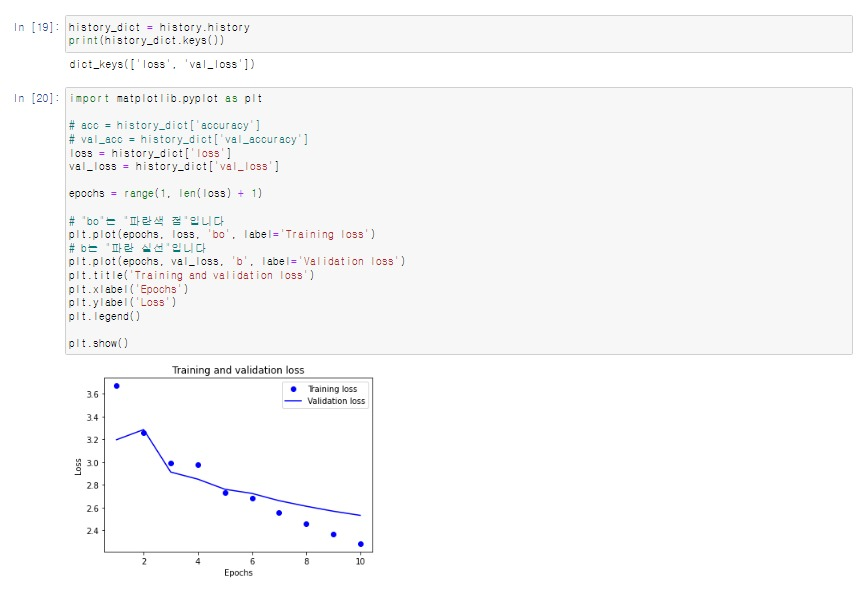

- 저의 다른 파일에 있는 함수입니다. 저런식으로 loss에 대한 시각화그래프도 그려보고싶었는데.. 다시 이 파일을 restart 할 수 없어 이렇게 아쉬움으로만 남깁니다.